In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
from scipy.integrate import solve_ivp

In [20]:
df = pd.read_csv("output.csv")
df

,precinct,party_detailed,votes,county_name,county_fips,candidate
0,001,DEMOCRAT,490,PIMA,4019,KYRSTEN SINEMA
1,0001 ACACIA,DEMOCRAT,1209,MARICOPA,4013,KYRSTEN SINEMA
2,0001 ACACIA,GREEN,84,MARICOPA,4013,ANGELA GREEN
3,0001 ACACIA,REPUBLICAN,891,MARICOPA,4013,MARTHA MCSALLY
4,0002 ACOMA,DEMOCRAT,757,MARICOPA,4013,KYRSTEN SINEMA
...,...,...,...,...,...,...
4114,0 DESERT CEDARS,GREEN,39,PINAL,4021,ANGELA GREEN
4115,0 DESERT CEDARS,REPUBLICAN,529,PINAL,4021,MARTHA MCSALLY
4116,0 EHRENBERG,DEMOCRAT,44,LA PAZ,4012,KYRSTEN SINEMA
4117,0 EHRENBERG,GREEN,8,LA PAZ,4012,ANGELA GREEN


In [21]:
df['total_votes'] = df.groupby('precinct')['votes'].transform('sum')

In [27]:
df['S0'] = df['total_votes']
df['I_final'] = df['votes']
df['R_final'] = 0.2 * df['I_final']
df['I_final'] -= df['R_final']

In [101]:
def sir_model(y,t,  beta, gamma):
    """SIR model equations."""
    S, I, R = y  # Ensure y is unpacked correctly
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [103]:
def sir_model1(t, y,  beta, gamma):
    """SIR model equations."""
    S, I, R = y  # Ensure y is unpacked correctly
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [99]:
def estimate_parameters(precinct_data, T=60):
    
    S0 = max(precinct_data['S0'].values[0], 1.5 * precinct_data['I_final'].values[0])
    I_final = max(precinct_data['I_final'].values[0], 1)
    R_final = max(precinct_data['R_final'].values[0], 1)

    def loss(params):
        beta, gamma = params

        t = np.linspace(0, T, 1000)
        sol = odeint(sir_model, [S0 - I_final - R_final, I_final, R_final], t, args=(beta, gamma))
        S_T, I_T, R_T = sol[-1]  

        error = (I_T - I_final)**2 + (R_T - R_final)**2
        return error

    initial_guess = [0.01, 0.01]

    result = minimize(loss, initial_guess, bounds=[(0.0001, 1), (0.0001, 1)], method='L-BFGS-B')
    return result.x if result.success else (None, None)


In [102]:
sir_params = {}

for candidate in df['candidate'].unique():
    precinct_data = df[df['candidate'] == candidate]
    beta, gamma = estimate_parameters(precinct_data)
    sir_params[candidate] = {'beta': beta, 'gamma': gamma}

for candidate, params in sir_params.items():
    print(f"{candidate}: β = {params['beta']:.5f}, γ = {params['gamma']:.5f}")

KYRSTEN SINEMA: β = 0.00510, γ = 0.00510
ANGELA GREEN: β = 0.01107, γ = 0.01107
MARTHA MCSALLY: β = 0.00650, γ = 0.00649


In [104]:
def plot_sir_model(candidate, beta, gamma, S0, I0, R0, T=60):
    """Simulates and plots the SIR model over time for a given candidate."""
    
    # Ensure reasonable initial conditions
    I0 = max(1, 0.01 * S0)  # At least one influenced voter
    S0 = max(1, S0 - I0 - R0)  # Adjust susceptible voters

    # Time range
    t = np.linspace(0, T, 1000)

    # Solve using solve_ivp (more stable than odeint)
    sol = solve_ivp(sir_model1, [0, T], [S0, I0, R0], args=(beta, gamma), method='DOP853', t_eval=t)

    # Extract results
    S, I, R = sol.y

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, label="Undecided (S)", color='blue')
    plt.plot(t, I, label="Influenced (I)", color='orange')
    plt.plot(t, R, label="Committed (R)", color='green')

    plt.xlabel("Days Before Election")
    plt.ylabel("Number of Voters")
    plt.title(f"SIR Model for {candidate}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [105]:
selected_candidate = "KYRSTEN SINEMA"
S0 = df[df["candidate"] == selected_candidate]["S0"].values[0]
I0 = df[df["candidate"] == selected_candidate]["I_final"].values[0]
R0 = df[df["candidate"] == selected_candidate]["R_final"].values[0]

In [106]:
beta, gamma = sir_params[selected_candidate]["beta"], sir_params[selected_candidate]["gamma"]

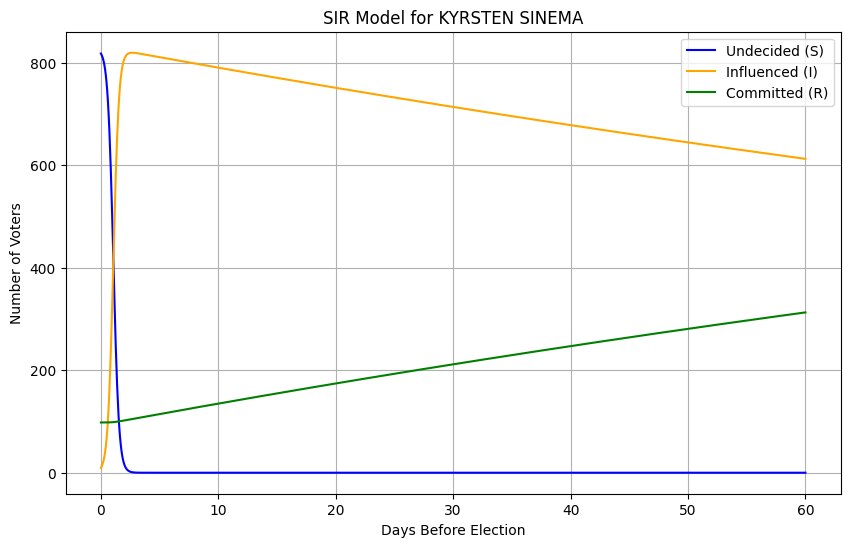

In [107]:
plot_sir_model(selected_candidate, beta, gamma, S0, I0, R0)